In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
from copy import deepcopy

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize

import pyForwardFolding as pyFF

jax.config.update("jax_debug_nans", True)
jax.config.update("jax_enable_x64", True)

data_path = "/home/chrhck/data/"


In [2]:
#Datasets = {
#"Northern Tracks":  pd.read_parquet("/data/ana/Diffuse/GlobalFit/NNMFit/datasets/SnowStorm_v2_tracks_baseline_galactic/dataset_tracks_galactic.parquet"),
#"Cascades": pd.read_parquet("/data/ana/Diffuse/GlobalFit/NNMFit/datasets/SnowStorm_v2_cscd_cascade_baseline/dataset_cscd_cascade_baseline_all_keys_galactic.parquet"),
#"Cascades Muon": pd.read_parquet("/data/ana/Diffuse/GlobalFit/NNMFit/datasets/SnowStorm_v2_cscd_muon_baseline/dataset_cscd_muon_baseline_all_keys_galactic.parquet"),
#}

ds_paths = {
    "Northern Tracks":  os.path.join(data_path, "dataset_tracks_galactic.parquet"),
    "Cascades": os.path.join(data_path, "dataset_cscd_cascade_baseline_all_keys_galactic.parquet"),
    "Cascades Muon": os.path.join(data_path, "dataset_cscd_muon_baseline_all_keys_galactic.parquet"),
}


dataset = {}
for key, ds_path in ds_paths.items():
    #dataset[det] = {}
    data  = pd.read_parquet(ds_path)


    if "MCType" in data.columns:
        # MuonGun is added as a template in the fit
        Filter_muon_gun = data["MCType"] == "MuonGun"
        data = data[~Filter_muon_gun]
    if key == "Northern Tracks":
        reco_e = "energy_truncated"
        reco_zenith = "zenith_MPEFit"
    elif key == "Cascades" or key == "Cascades Muon":
        reco_e = 'energy_monopod'
        reco_zenith = 'zenith_monopod'
    dataset[key] = {
        "true_energy": jnp.asarray(data.MCPrimaryEnergy),
        "reco_energy": jnp.asarray(data[reco_e]),
        "log10_reco_energy": jnp.log10(jnp.asarray(data[reco_e])),
        "reco_zenith": jnp.asarray(data[reco_zenith]),
        "cos_reco_zenith": jnp.cos(jnp.asarray(data[reco_zenith])),
        "baseline_weight": jnp.asarray(data.fluxless_weight),
        "conv_weight": jnp.asarray(data.mceq_conv_H4a_SIBYLL23c),
        "prompt_weight": jnp.asarray(data.mceq_pr_H4a_SIBYLL23c),
        "summary_stat": jnp.log10(jnp.asarray(data[reco_e])),
        "barr_h_gradient": jnp.asarray(data.barr_h_mceq_H4a_SIBYLL23c),
        "barr_w_gradient": jnp.asarray(data.barr_w_mceq_H4a_SIBYLL23c),
        "barr_y_gradient": jnp.asarray(data.barr_y_mceq_H4a_SIBYLL23c),
        "barr_z_gradient": jnp.asarray(data.barr_z_mceq_H4a_SIBYLL23c),
        "conv_weight_alt": jnp.asarray(data.mceq_conv_GST4_SIBYLL23c),
        "prompt_weight_alt": jnp.asarray(data.mceq_pr_GST4_SIBYLL23c),
    }
    if key == "Cascades" or key == "Cascades Muon":
        print("Adding additional variables for cascades")
        dataset[key]["log_PF_at100GeV_conv_a"] =  jnp.asarray(data.log_PF_at100GeV_conv_a)
        dataset[key]["log_PF_at100GeV_conv_b"] =  jnp.asarray(data.log_PF_at100GeV_conv_b)
        dataset[key]["log_PF_at100GeV_conv_c"] =  jnp.asarray(data.log_PF_at100GeV_conv_c)
        dataset[key]["log_PF_at100GeV_pr_a"] =  jnp.asarray(data.log_PF_at100GeV_pr_a)
        dataset[key]["log_PF_at100GeV_pr_b"] =  jnp.asarray(data.log_PF_at100GeV_pr_b)
        dataset[key]["log_PF_at100GeV_pr_c"] =  jnp.asarray(data.log_PF_at100GeV_pr_c)
    del data





Adding additional variables for cascades
Adding additional variables for cascades


In [3]:
with open(os.path.join(data_path, "snowstorm_v2_All_FullSamples_DroppedBins_cscd_15zen.pickle"), "rb") as hdl:
    grads = pickle.load(hdl)
    nt_grads = grads["IC86_pass2_SnowStorm_v2_tracks"]
    casc_grads = grads["IC86_pass2_SnowStorm_v2_cscd_cascade"]
    casc_muon_grads = grads["IC86_pass2_SnowStorm_v2_cscd_muon"]

    nt_grads["livetime"] = nt_grads["settings"]["config"]["IC86_pass2_SnowStorm_v2_tracks"]["livetime"]
    casc_grads["livetime"] = casc_grads["settings"]["config"]["IC86_pass2_SnowStorm_v2_cscd_cascade"]["livetime"]
    casc_muon_grads["livetime"] = casc_muon_grads["settings"]["config"]["IC86_pass2_SnowStorm_v2_cscd_muon"]["livetime"]

with open(os.path.join(data_path, "snowstorm_IC86_pass2_SnowStorm_v2_tracks.pickle"), "wb") as hdl:
    pickle.dump(nt_grads, hdl)
with open(os.path.join(data_path,"snowstorm_IC86_pass2_SnowStorm_v2_cscd_cascade.pickle"), "wb") as hdl:
    pickle.dump(casc_grads, hdl)
with open(os.path.join(data_path,"snowstorm_IC86_pass2_SnowStorm_v2_cscd_muon.pickle"), "wb") as hdl:
    pickle.dump(casc_muon_grads, hdl)

with open(os.path.join(data_path,"cscd_muongun_ALL_KDE_15zen_manual_ssq.pickle"), "rb") as hdl:
    muongun = pickle.load(hdl)

with open(os.path.join(data_path,"cscd_muongun_cscd_cascade_KDE_15zen_manual_ssq.pickle"), "wb") as hdl:
    pickle.dump(muongun["IC86_pass2_SnowStorm_v2_cscd_cascade"], hdl)

with open(os.path.join(data_path,"cscd_muongun_cscd_muon_KDE_15zen_manual_ssq.pickle"), "wb") as hdl:
    pickle.dump(muongun["IC86_pass2_SnowStorm_v2_cscd_muon"], hdl)


In [4]:
ana = pyFF.config.analysis_from_config("Global_Fit_config.yaml")
#ana = pyFF.config.analysis_from_config("Global_Fit_config_reduced.yaml")
lik = pyFF.likelihood.PoissonLikelihood(ana)

In [18]:
model_parameters = {
    "astro_norm": 1.44,
    "astro_index": 2.37,
    "conv_norm": 1.0,
    "prompt_norm": 0.0,
    "delta_gamma": 0.0,
    "barr_h": 0.0,
    "barr_w": 0.0,
    "barr_y": 0.0,
    "barr_z": 0.0,
    "lambda_int": 0.0,
    "dom_eff": 1.0,
    "ice_abs": 1.0,
    "ice_scat":1.0,
    "ice_holep0": -0.27,
    "ice_holep1":-0.042,
    "muon_template": 1.0,
    "muongun_template": 1.0,
    "e_threshold": 0.0
}

In [19]:
from pprint import pprint

pprint(ana.exposed_parameters)

{'astro_index',
 'astro_norm',
 'barr_h',
 'barr_w',
 'barr_y',
 'barr_z',
 'conv_norm',
 'delta_gamma',
 'dom_eff',
 'e_threshold',
 'ice_abs',
 'ice_holep0',
 'ice_holep1',
 'ice_scat',
 'lambda_int',
 'muon_template',
 'muongun_template',
 'prompt_norm'}


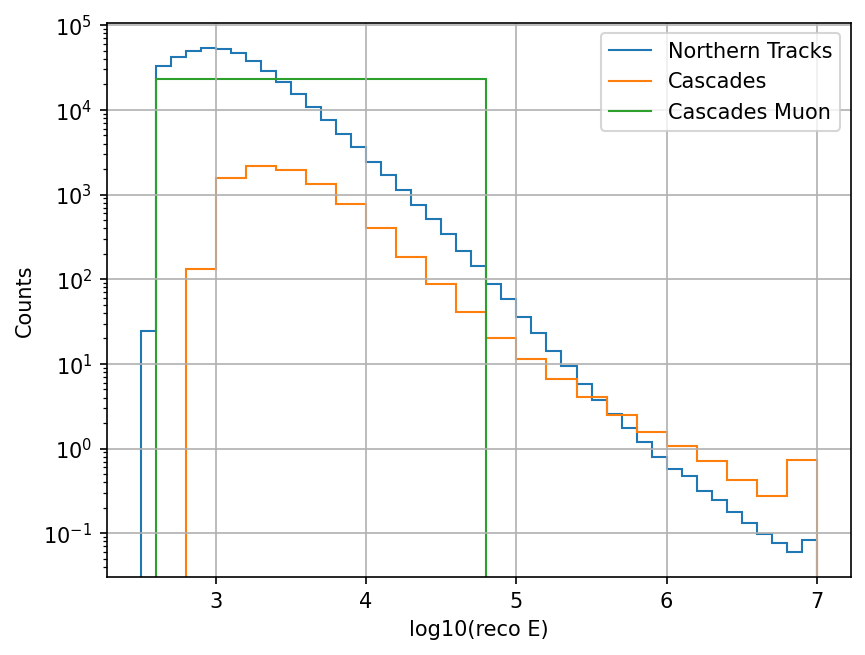

In [20]:
#dataset = {"Northern Tracks": input_variables}
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
plt.figure(dpi=150)
for det in dataset.keys():
    binning = ana.expectations[det].binning
    hsum = hist[det].reshape(binning.hist_dims).sum(axis=1)
    plt.stairs(edges = binning.bin_edges[0], values=hsum, label = det)
    plt.yscale("log")
plt.xlabel("log10(reco E)")
plt.ylabel("Counts")
plt.legend()
plt.grid()
obs = hist # asimov

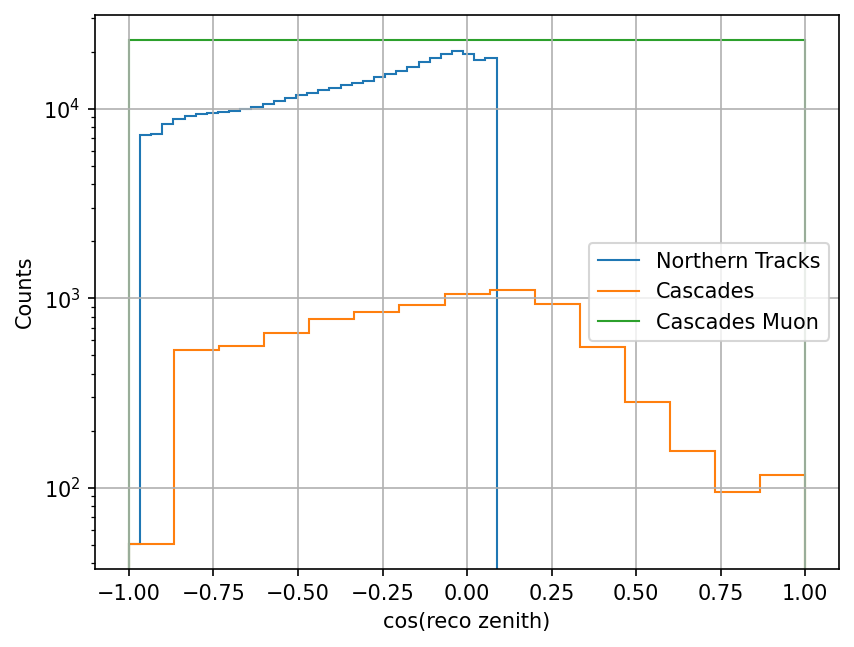

In [8]:
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
plt.figure(dpi=150)
for det in dataset.keys():
    binning = ana.expectations[det].binning
    hsum = hist[det].reshape(binning.hist_dims).sum(axis=0)
    plt.stairs(edges = binning.bin_edges[1], values=hsum, label = det)
    plt.yscale("log")
plt.xlabel("cos(reco zenith)")
plt.ylabel("Counts")
plt.legend()
plt.grid()

In [9]:
bound_config = {
    "conv_norm": (0., np.inf),
    "astro_norm": (0., np.inf),
    "astro_index": (1.0, 5.0),
    "delta_gamma": (-0.1, 0.1),
    "barr_h": (-1, 5),
    "barr_w": (-1, 5),
    "barr_y": (-1, 5),
    "barr_z": (-0.244, 5),
    "prompt_norm": (0., np.inf),
    "lambda_int": (-1., 2),
    "dom_eff": (0.9, 1.1),
    "ice_abs": (0.9, 1.1),
    "ice_scat": (0.9, 1.1),
    "ice_holep0": (-0.84, 0.3),
    "ice_holep1": (-0.134, 0.05),
    "muon_template": (0., np.inf),
    "muongun_template": (0., np.inf),
    "e_threshold": (-1.301, 1.301),
}

defaults = {
    "astro_norm": 1.44,
    "astro_index": 2.37,
    "conv_norm": 1.0,
    "prompt_norm": 1.0,
    "delta_gamma": 0.0,
    "barr_h": 0.0,
    "barr_w": 0.0,
    "barr_y": 0.0,
    "barr_z": 0.0,
    "lambda_int": 0.0,
    "dom_eff": 1.0,
    "ice_abs": 1.0,
    "ice_scat":1.0,
    "ice_holep0": -0.27,
    "ice_holep1":-0.042,
    "muon_template": 1.0,
    "muongun_template": 1.0,
    "e_threshold": 0.0
}


priors = {
    "barr_h": (0, 0.15),
    "barr_w": (0, 0.4),
    "barr_y": (0, 0.3),
    "barr_z": (0, 0.12),
    "lambda_int": (0, 1),
    "muon_norm": (0, 0.5),
}

In [25]:
hist, hist_ssq = ana.evaluate(dataset, defaults)
obs = hist

#mini = pyFF.minimizer.MinuitMinimizer(lik, obs, dataset, bound_config, defaults, {}, {})
mini = pyFF.minimizer.ScipyMinimizer(lik, obs, dataset, bound_config, defaults, {}, {"astro_norm": 1.6})
res = mini.minimize()


In [23]:
mini.fixed_pars

{'astro_norm': 1.44}

In [22]:
res, res2

((  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
    success: True
     status: 0
        fun: -2751402.7291982663
          x: [-7.305e-05  2.370e+00 ...  1.000e+00  9.999e-01]
        nit: 1
        jac: [ 5.747e-01  1.078e+00 ...  1.577e+02  2.701e-03]
       nfev: 4
       njev: 4
   hess_inv: <17x17 LbfgsInvHessProduct with dtype=float64>,
  {'e_threshold': np.float64(-7.304917354176003e-05),
   'astro_index': np.float64(2.369839658041353),
   'astro_norm': 1.6,
   'prompt_norm': np.float64(0.9998829620739805),
   'lambda_int': np.float64(-0.00011703792601947829),
   'ice_holep0': np.float64(-0.2699332883821689),
   'barr_h': np.float64(-0.00011703792601947829),
   'barr_w': np.float64(-0.00011703792601947829),
   'ice_abs': np.float64(1.000011703792602),
   'ice_holep1': np.float64(-0.042010767489193794),
   'conv_norm': np.float64(0.9998829620739805),
   'delta_gamma': np.float64(1.170379260194783e-05),
   'muongun_template': np.float64(0.9998829620739805),
   '

In [26]:
astro_norms = np.linspace(0, 3, 50)
llhs = []
pars = []

for astro_norm in astro_norms:
    fixed_params = {"astro_norm": astro_norm}
    mini = pyFF.minimizer.ScipyMinimizer(lik, obs, dataset, bound_config, defaults, {}, fixed_params)
    
    res, xmin, fun = mini.minimize()
    llhs.append(fun)
    pars.append(xmin)




In [27]:
pd.DataFrame(pars)

,e_threshold,astro_index,astro_norm,prompt_norm,lambda_int,ice_holep0,barr_h,barr_w,ice_abs,ice_holep1,conv_norm,delta_gamma,muongun_template,barr_z,barr_y,dom_eff,ice_scat,muon_template
0,8.036018e-05,2.370000,0.000000,1.000607,0.000494,-0.269939,-0.000359,0.000105,0.999467,-0.041811,1.006145,-7.032168e-03,1.000770,0.002203,0.000486,0.999968,0.999798,1.000030
1,7.917128e-05,2.369905,0.061224,1.000531,0.000467,-0.269735,-0.000365,0.000114,0.999724,-0.041914,1.005945,-6.394985e-03,1.000765,0.002096,0.000491,1.000000,0.999832,1.000036
2,3.867132e-06,2.369996,0.122449,1.000093,0.000009,-0.270002,0.000009,0.000014,0.999931,-0.042003,1.002347,-5.744753e-05,1.000163,0.000031,0.000017,1.000042,1.000009,1.000010
3,3.786700e-06,2.369996,0.183673,1.000076,0.000011,-0.270002,0.000006,0.000013,0.999906,-0.042003,1.001965,-9.650073e-05,1.000140,0.000043,0.000018,1.000047,0.999991,1.000009
4,6.046018e-06,2.369992,0.244898,1.000073,0.000033,-0.270040,-0.000014,0.000016,0.999748,-0.042146,1.001680,-4.036415e-04,1.000138,0.000141,0.000039,1.000071,0.999862,1.000008
5,3.720691e-06,2.369996,0.306122,1.000068,0.000009,-0.270001,0.000008,0.000013,0.999930,-0.042007,1.001909,-6.301749e-05,1.000135,0.000033,0.000017,1.000041,1.000010,1.000008
6,3.669266e-06,2.369996,0.367347,1.000065,0.000008,-0.270002,0.000011,0.000013,0.999958,-0.042006,1.001904,-3.515249e-05,1.000133,0.000024,0.000016,1.000026,1.000012,1.000008
7,3.660253e-06,2.369996,0.428571,1.000060,0.000007,-0.270002,0.000011,0.000014,0.999961,-0.042006,1.001804,-3.179717e-05,1.000126,0.000023,0.000015,1.000024,1.000012,1.000008
8,3.649714e-06,2.369996,0.489796,1.000055,0.000007,-0.270002,0.000011,0.000014,0.999965,-0.042006,1.001701,-2.845486e-05,1.000119,0.000022,0.000015,1.000022,1.000012,1.000007
9,3.623869e-06,2.369996,0.551020,1.000051,0.000007,-0.270001,0.000012,0.000014,0.999968,-0.042006,1.001589,-2.541376e-05,1.000111,0.000021,0.000015,1.000020,1.000012,1.000007


(0.0, 36.0)

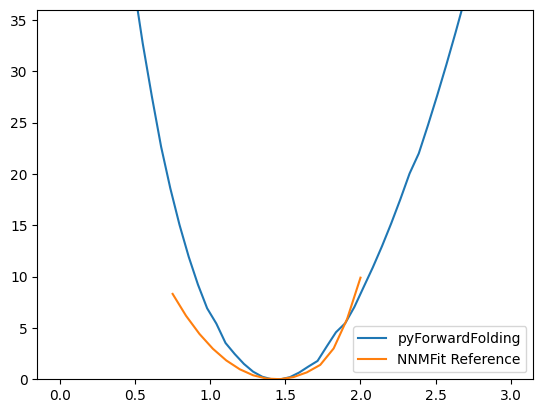

In [28]:
ref_data = pd.read_hdf(os.path.join(data_path, "ScanResults.hdf"))
plt.plot(astro_norms, 2*(np.asarray(llhs) - min(llhs)), label= "pyForwardFolding")
sort_by = np.argsort(ref_data.astro_norm.loc["astro_norm"])
plt.plot(ref_data.astro_norm.loc["astro_norm"][sort_by], 2*ref_data.llh.loc["astro_norm"][sort_by], label = "NNMFit Reference")
plt.legend()
plt.ylim(0, 36)

In [31]:
edges = jnp.asarray([0, 1, 2, 3], )
bi = jnp.digitize(jnp.asarray([4]), edges)
jnp.bincount(bi, length=len(edges)-1)




Array([0, 0, 0], dtype=int32)

In [35]:
astro_norms = np.linspace(0, 3, 100)
llhs = []
hist, hist_ssq = ana.evaluate(dataset, defaults)
obs = hist

fixed = {}
dest_args = pyFF.minimizer.destructure_args(defaults, ana.exposed_parameters, fixed)
re_args = pyFF.minimizer.restructure_args(dest_args, ana.exposed_parameters, fixed)

wllh = pyFF.minimizer.WrappedLLH(lik, obs, dataset, {}, [])
wllh(dest_args)


jitted_llh = jax.jit(wllh)

for an in astro_norms:
    pset = deepcopy(defaults)
    pset["astro_norm"] = an
    dest_args = pyFF.minimizer.destructure_args(pset, ana.exposed_parameters, fixed)
    
    llhs.append(jitted_llh(dest_args))






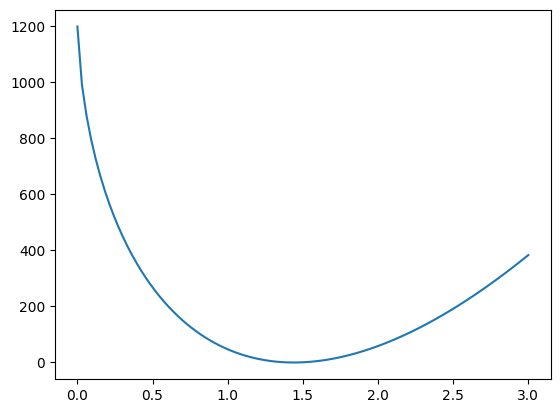

In [36]:
plt.plot(astro_norms, llhs)

In [13]:

class Scipy_Minimizer:
    def __init__(self,
                 llh: pyFF.likelihood.AbstractLikelihood,
                 obs: dict,
                 dataset: dict,
                 exposed_vars,
                 bounds,
                 seeds,
                 priors = {},
                 fixed_pars = {}):
        prior_objects = []
        for factor, pars in priors.items():
            prior_objects.append(pyFF.likelihood.GaussianPrior(factor, pars))
        wrapped_lh = pyFF.minimizer.WrappedLLH(llh, obs, dataset, fixed_pars, prior_objects)
        self.fmin_and_grad = jax.jit(jax.value_and_grad(wrapped_lh))
        self.par_idx_map = pyFF.minimizer.flat_index_dict_mapping(exposed_vars, fixed_pars)
        bounds_lower = []
        bounds_upper = []
        self.seeds = []
        print(self.par_idx_map)
        for par_name, par in self.par_idx_map.items():
                lower, upper = bounds[par]
                bounds_lower.append(lower)
                bounds_upper.append(upper)
                self.seeds.append(seeds[par])
        self.bounds = scipy.optimize.Bounds(bounds_lower, bounds_upper)
    def minimize(self):
        result = scipy.optimize.minimize(
            self.fmin_and_grad,
            self.seeds,
            bounds=self.bounds,
            jac=True,
            method="L-BFGS-B",
            tol=1e-8,
            options={"maxls": 50, }
            )
        return result

In [14]:
minimizer = Scipy_Minimizer(
    lik, 
    obs,
    dataset,
    ana.exposed_parameters,
    bound_config,
    defaults,
    priors,
    fixed_pars = {}
    )
injected_pars = []
print(ana.exposed_parameters())
print(lik.llh(obs, dataset, model_parameters))
for factor, pars in minimizer.par_idx_map.items():
    for par, val in pars.items():
        injected_pars.append(model_parameters[factor][par])
print(injected_pars)
injec_llh = minimizer.fmin_and_grad(injected_pars)
print(injec_llh)

{'barr_h': 0, 'ice_holep1': 1, 'ice_abs': 2, 'ice_holep0': 3, 'astro_index': 4, 'dom_eff': 5, 'delta_gamma': 6, 'conv_norm': 7, 'barr_z': 8, 'barr_y': 9, 'barr_w': 10, 'ice_scat': 11, 'lambda_int': 12, 'prompt_norm': 13, 'e_threshold': 14, 'astro_norm': 15, 'muongun_template': 16, 'muon_template': 17}


KeyError: 0

In [10]:

result = minimizer.minimize()

In [11]:
print(result)
for factor, pars in minimizer.par_idx_map.items():
    print(factor)
    for par, val in pars.items():
        print(f"{par}: {result.x[val]:0.3f}, grad: {result.jac[val]:0.3f}")

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.0002783150169364209
        x: [ 1.760e+00  2.513e+00  9.999e-01  4.794e-05  2.827e-05
            -5.829e-05 -1.370e-05  5.693e-05  2.033e-04  1.280e+00]
      nit: 186
      jac: [ 1.819e-03  1.032e-02 -6.169e-03 -1.026e-02 -5.315e-03
             2.178e-03  3.030e-03  4.380e-03 -2.801e-03  2.563e-03]
     nfev: 211
     njev: 211
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
powerlaw
flux_norm: 1.760, grad: 0.002
spectral_index: 2.513, grad: 0.010
conv_norm
flux_norm: 1.000, grad: -0.006
delta_gamma
delta_gamma: 0.000, grad: -0.010
barr_gradients
barr_h: 0.000, grad: -0.005
barr_w: -0.000, grad: 0.002
barr_z: -0.000, grad: 0.003
barr_y: 0.000, grad: 0.004
CR_intp
lambda_int: 0.000, grad: -0.003
prompt_norm
flux_norm: 1.280, grad: 0.003


In [ ]:
import iminuit


class Minuit_Minimizer:
    def __init__(self,
                 llh: pyFF.likelihood.AbstractLikelihood,
                 obs: dict,
                 dataset: dict,
                 exposed_vars,
                 bounds,
                 Seeds,
                 Priors = {},
                 fixed_pars = {}):
        prior_objects = []
        for factor, pars in Priors.items():
            prior_objects.append(pyFF.likelihood.GaussianPrior(factor, pars))
        wrapped_lh = pyFF.minimizer.WrappedLLH(llh,
                                               obs,
                                               dataset,
                                               fixed_pars,
                                               prior_objects)
        self.func = jax.jit(wrapped_lh)
        self.grad = jax.jit(jax.grad(wrapped_lh))
        print("Compiled Likelihood function and gradient")
        self.par_idx_map = pyFF.minimizer.flat_index_dict_mapping(exposed_vars, fixed_pars)
        self.seeds = []
        self.par_names = []
        bound_list = []
        #print(self.par_idx_map)
        for factor, pars in self.par_idx_map.items():
            for par in pars:
                self.seeds.append(Seeds[factor][par])
                self.par_names.append(f"{factor}_{par}")
                lower, upper = bounds[factor][par]
                bound_list.append([lower, upper])
        print("Setup Minimizer")
        self.minuit = iminuit.Minuit(
            self.func,
            self.seeds,
            grad=self.grad,
            name=self.par_names
        )
        self.minuit.errordef = self.minuit.LIKELIHOOD
        self.minuit.limits = np.array(bound_list)
        self.minuit.strategy = 1
        self.minuit.tol = 1e-2
        self.minuit.print_level = 0
    def _build_message(self):
        """
        Helper function for building a short fit message.
        """
        if self.minuit.valid:
            message = "Optimization terminated successfully"
            if self.minuit.accurate:
                message += "."
            else:
                message += ", but uncertainties are unrealiable."
        else:
            message = "Optimization failed."
            fmin = self.minuit.fmin
            if fmin.has_reached_call_limit:
                message += " Call limit was reached."
            if fmin.is_above_max_edm:
                message += " Estimated distance to minimum too large."

        return message
    def minimize(self):
        print("Starting Minimization")
        self.minuit.migrad()
        print("Finished Minimization")
        minimizer_info = {
            'success': self.minuit.valid,
            'message': self._build_message(),
            'nfev': self.minuit.nfcn,
            'njev': self.minuit.ngrad,
            'hess_inv': self.minuit.covariance,
        }
        res_dict = {
            var: self.minuit.values[var]
            for var in self.par_names
        }
        fun = self.minuit.fval
        print("best-fit llh: ", fun)
        print("----------------")
        print("best-fit parameters:")
        for factor, pars in self.par_idx_map.items():
            print("")
            print(factor)
            for par, val in pars.items():
                print(f"{par}: {res_dict[factor+'_'+par]:0.3f}")
        print("----------------")
        
        return minimizer_info, res_dict, fun

In [13]:
astro_scan = np.linspace(0, 2.5, 20)
scan_res = []
par_res = []
for astro in astro_scan:
    print("#####################")
    print("astro_norm:", astro)
    minuit_min = pyFF.minimizer.Minuit_Minimizer(lik,
                                obs,
                                dataset,
                                ana.exposed_variables(),
                                bound_config,
                                defaults,
                                Priors = priors,
                                fixed_pars = {"powerlaw": {"flux_norm": astro}})
    minuit_result = minuit_min.minimize()
    #print(minuit_result[2])
    scan_res.append(minuit_result[2])
    par_res.append(minuit_result[1])
    print("#####################")

#####################
astro_norm: 0.0
Compiled Likelihood function and gradient
Setup Minimizer
Starting Minimization
Finished Minimization
best-fit llh:  183.61697549345195
----------------
best-fit parameters:

powerlaw
spectral_index: 2.370

conv_norm
flux_norm: 1.264

delta_gamma
delta_gamma: -0.100

barr_gradients
barr_h: -0.028
barr_w: 0.506
barr_z: -0.105
barr_y: -0.227

CR_intp
lambda_int: -0.817

effective_veto
e_threshold: 1.146

prompt_norm
flux_norm: 10.997

SnowStormSystematics
dom_eff: 1.002
ice_abs: 1.007
ice_scat: 1.006
ice_holep0: -0.288
ice_holep1: -0.052

MuonTemplate
flux_norm: 0.328

MuonGunTemplate
flux_norm: 0.920
----------------
#####################
#####################
astro_norm: 0.13157894736842105
Compiled Likelihood function and gradient
Setup Minimizer
Starting Minimization
Finished Minimization
best-fit llh:  83.15434319752104
----------------
best-fit parameters:

powerlaw
spectral_index: 1.685

conv_norm
flux_norm: 1.306

delta_gamma
delta_gamma: -0.

In [14]:
ref_data = pd.read_hdf("/data/ana/Diffuse/GlobalFit/fits/Tracks_NoCscd/SPL/Gradient_baseline/asimov/poisson/ScanResults.hdf")
print(ref_data.loc["freefit"])

    CR_grad astro_norm    barr_h    barr_w    barr_y    barr_z conv_norm  \
0  0.000033   1.440008 -0.000002  0.000002 -0.000012  0.000009  1.000003   

  delta_gamma dom_eff effective_veto fit_success gamma_astro ice_abs  \
0         0.0     1.0       1.000003        True    2.370002     1.0   

  ice_holep0 ice_holep1 ice_scat  llh muon_norm muongun_norm prompt_norm  
0  -0.269998     -0.042      1.0  0.0  1.000022          1.0    0.999953  


0         0.75
1     0.839286
2     0.928571
3     1.017857
4     1.107143
5     1.196429
6     1.285714
7        1.375
8     1.464286
9     1.553571
10    1.642857
11    1.732143
12    1.821429
13    1.910714
14         2.0
Name: astro_norm, dtype: object


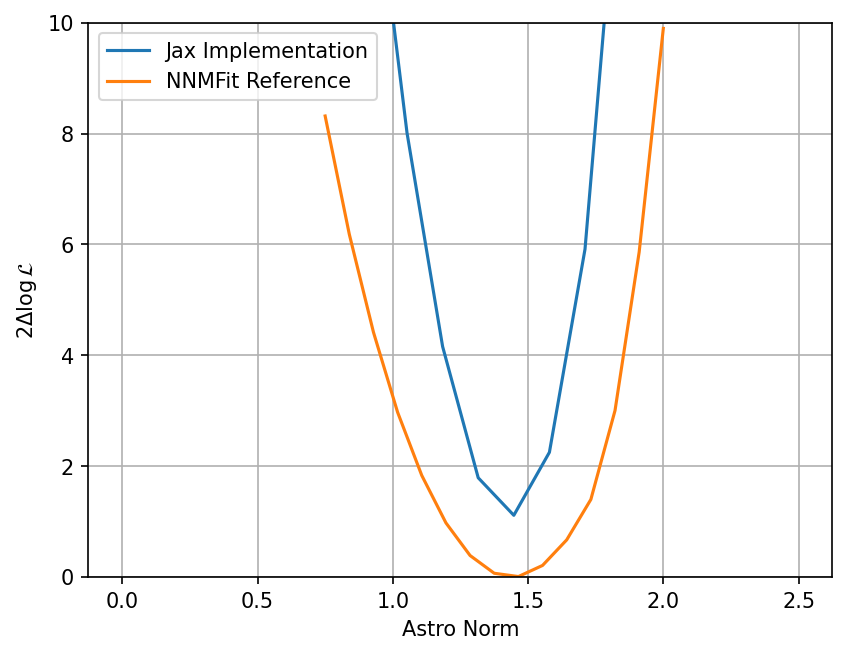

In [16]:
fig, ax = plt.subplots(dpi=150)
print(ref_data.astro_norm.loc["astro_norm"])
ax.plot(astro_scan, np.array(scan_res), label = "Jax Implementation")
sort_by = np.argsort(ref_data.astro_norm.loc["astro_norm"])
ax.plot(ref_data.astro_norm.loc["astro_norm"][sort_by], 2*ref_data.llh.loc["astro_norm"][sort_by], label = "NNMFit Reference")
ax.set_xlabel("Astro Norm")
ax.set_ylabel(r"2$\Delta  \log \mathcal{L}$")
ax.set_ylim(0, 10)  
ax.grid(True)
ax.legend()

In [13]:
prior_objects = []
for factor, pars in priors.items():
    prior_objects.append(pyFF.likelihood.GaussianPrior(factor, pars))
wrapped_lh = pyFF.minimizer.WrappedLLH(
    lik,
    obs,
    dataset,
    {},
    prior_objects
    )
hess_func = jax.jit(jax.hessian(wrapped_lh))

In [14]:
injected_pars = []
minimizer = Minuit_Minimizer(
    lik,
    obs,
    dataset,
    ana.exposed_variables(),
    bound_config,
    defaults,
    Priors = priors,
    fixed_pars = {}
    )
for factor, pars in minimizer.par_idx_map.items():
    for par, val in pars.items():
        injected_pars.append(model_parameters[factor][par])
hesse = hess_func(injected_pars)

Compiled Likelihood function and gradient
Setup Minimizer


In [ ]:
import jax.profiler

llh_function = jax.jit(wrapped_lh)
# Start profiling and collect trace data
#with jax.profiler.trace():
jax.profiler.start_trace("/tmp/profile",)
llh_function(injected_pars)
jax.profiler.stop_trace()

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/message_lite.cc:449] tensorflow.profiler.XSpace exceeded maximum protobuf size of 2GB: 2314320987


In [33]:
cov = np.linalg.inv(hesse)
for factor, pars in minimizer.par_idx_map.items():
    print("------")
    print(factor)
    for par, val in pars.items():
        print(f"{par}: {injected_pars[val]:0.2f} +- {np.sqrt(cov[val, val]):0.3f}")

------
powerlaw
flux_norm: 1.80 +- 1.743
spectral_index: 2.52 +- 0.298
------
conv_norm
flux_norm: 1.00 +- 0.087
------
delta_gamma
delta_gamma: 0.00 +- 0.021
------
barr_gradients
barr_h: 0.00 +- 0.098
barr_w: 0.00 +- 0.252
barr_z: 0.00 +- 0.075
barr_y: 0.00 +- 0.134
------
CR_intp
lambda_int: 0.00 +- 0.227
------
prompt_norm
flux_norm: 1.00 +- 12.167
------
SnowStormSystematics
dom_eff: 1.00 +- 0.000
ice_abs: 1.00 +- 0.000
ice_scat: 1.00 +- 0.000
ice_holep0: -0.27 +- 0.000
ice_holep1: -0.04 +- 0.000


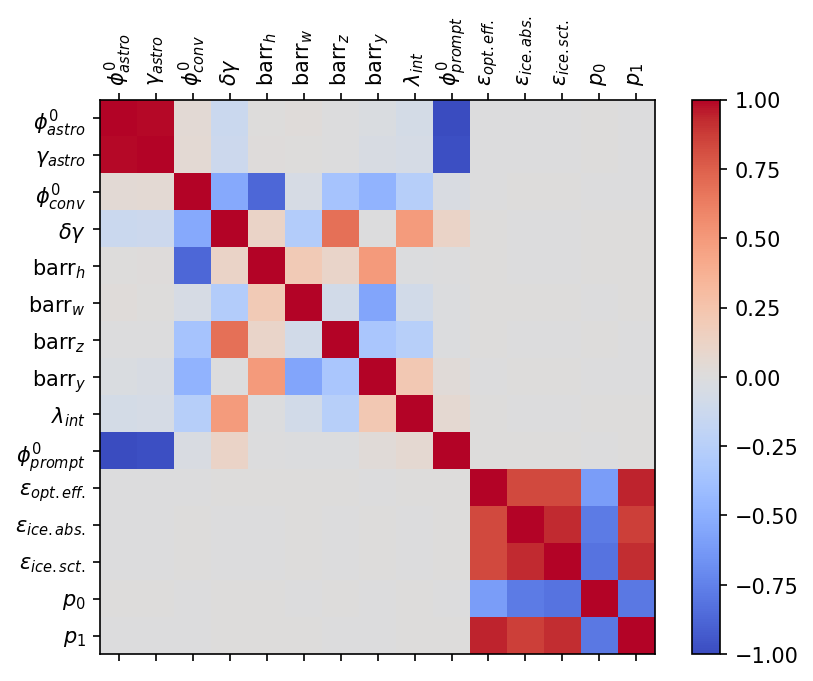

In [41]:
par_name_dict = {
    "powerlaw": {"flux_norm": r"$\phi_{astro}^0$", "spectral_index": r"$\gamma_{astro}$"},
    "conv_norm": {"flux_norm": r"$\phi_{conv}^0$"},
    "prompt_norm": {"flux_norm": r"$\phi_{prompt}^0$"},
    "delta_gamma": {"delta_gamma": r"$\delta \gamma$"},
    "barr_gradients": {"barr_h": r"barr-h", "barr_w": r"barr-w", "barr_y": r"barr-y", "barr_z": r"barr-z"},
    "CR_intp": {"lambda_int": r"$\lambda_{CR}$"},
    "SnowStormSystematics": {"dom_eff": r"$\epsilon_{opt. eff.}$", "ice_abs": r"$\epsilon_{ice. abs.}$", "ice_scat": r"$\epsilon_{ice. sct.}$", "ice_holep0": r"$p_0$", "ice_holep1": r"$p_1$"},   
}

par_names = []
for factor, pars in minimizer.par_idx_map.items():
    for par, val in pars.items():
        par_names.append(par_name_dict[factor][par])

fig, ax = plt.subplots(dpi=150)
p = ax.matshow(cov/np.sqrt(np.diag(cov)[:, None]*np.diag(cov)[None, :]), vmin = -1, vmax = 1, cmap="coolwarm")
fig.colorbar(p)
ax.set_xticks(range(len(minimizer.par_names)), par_names, rotation=90)
ax.set_yticks(range(len(minimizer.par_names)), par_names)

In [20]:
jax.profiler.start_trace("/tmp/profile",)
minuit_result = minimizer.minimize()
jax.profiler.stop_trace()
for factor, pars in minuit_min.par_idx_map.items():
    print(factor)
    for par, val in pars.items():
        print(f"{par}: {minuit_result[1][factor + "_" + par]:0.3f}")
print("llh: " , minuit_result[2])

Starting Minimization


Finished Minimization
best-fit llh:  0.005182422397759163
----------------
best-fit parameters:

powerlaw
flux_norm: 1.388
spectral_index: 2.358

conv_norm
flux_norm: 1.001

delta_gamma
delta_gamma: -0.000

barr_gradients
barr_h: -0.000
barr_w: -0.001
barr_z: -0.001
barr_y: -0.001

CR_intp
lambda_int: 0.001

prompt_norm
flux_norm: 0.370

SnowStormSystematics
dom_eff: 1.000
ice_abs: 1.000
ice_scat: 1.000
ice_holep0: -0.269
ice_holep1: -0.042
----------------
powerlaw
spectral_index: 2.358
conv_norm
flux_norm: 1.001
delta_gamma
delta_gamma: -0.000
barr_gradients
barr_h: -0.000
barr_w: -0.001
barr_z: -0.001
barr_y: -0.001
CR_intp
lambda_int: 0.001
prompt_norm
flux_norm: 0.370
SnowStormSystematics
dom_eff: 1.000
ice_abs: 1.000
ice_scat: 1.000
ice_holep0: -0.269
ice_holep1: -0.042
llh:  0.005182422397759163


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/message_lite.cc:449] tensorflow.profiler.XSpace exceeded maximum protobuf size of 2GB: 4681815112
